## Fine-tuning BERT for Twitter Sentiment Analysis

### There are 4 Steps to fine-tune the model
#### 1. Tokenizing Text
#### 2. Defining a Model Architecture
#### 3. Training Classification Layer Weights
#### 4. Fine-tuning DistilBERT and Training All Weights

### Installing transformers

In [5]:
!pip install transformers

### Loading dataset

In [6]:
from pathlib import Path
import numpy as np
import pandas as pd

In [7]:
dataset_dir = Path("/kaggle/input/tweeter-clean")
train = pd.read_csv(dataset_dir/"train_new.csv")
test = pd.read_csv(dataset_dir/"test_new.csv")

In [8]:
train.head()

,sentiment_score,tweet
0,0,that is a bummer You should a got David Carr o...
1,0,is upset that he can not update his Facebook b...
2,0,I dived many times for the ball Managed to sav...
3,0,my whole body feels itchy and like its on fire
4,0,no it is not behaving at i am mad why am i her...


#### splitting the dataset into TRAIN, VAL, and TEST

In [9]:
from sklearn.model_selection import train_test_split
from time import time
t0 = time()
X_train, X_val, y_train, y_val = train_test_split(train.tweet, train.sentiment_score,train_size=0.6, test_size=0.02, random_state=43, stratify=train.sentiment_score)
X_test, y_test = test.tweet, test.sentiment_score
print(f"time taken to split into TRAIN and VAL: {time()-t0} s")
X_train.shape, X_val.shape, X_test.shape

time taken to split into TRAIN and VAL: 0.441051721572876 s


((957445,), (31915,), (359,))

In [10]:
y_train.value_counts(), y_val.value_counts()

(0    478851
 1    478594
 Name: sentiment_score, dtype: int64,
 0    15962
 1    15953
 Name: sentiment_score, dtype: int64)

#### 1. Tokenizing Text
Tokenization is a process to make sentence in the form which is expected by the Model (DistilBERT).
We can do this using Huggingface APIs.

<img src="http://jalammar.github.io/images/distilBERT/bert-distilbert-tokenization-2-token-ids.png">

Different pre-trained models utilize different methods to to tokenizer textual inputs (as you can see in the above picture how DistilBERT's includes special tokens such as \[CLS\] and \[SEP\] in its tokenization scheme).

So, it is necessary to instantiate a tokenizer object that is specific to our chosen model.

To get the tokenizer used by `distilbert-base-uncased`, we pass the model's name to the `.from_pretrained()` method of the `DistilBertTokenizerFast` class.

In [11]:
from transformers import DistilBertTokenizerFast

checkpoint = "distilbert-base-uncased"
# Instantiate DistilBert tokenizer. We use the faster version to optimizer runtime
tokenizer = DistilBertTokenizerFast.from_pretrained(checkpoint)
tokenizer

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

__Let's tokenize `TRAIN`, `VAL`, and `TEST` split in batches using the tokenizer's `.batch_encode_plus()` method.__

A few arguments to understand in tokenization:
- `max_length` --> Controls the maximum number of words to tokenize in a give text.
- `padding` --> If set to `longest`, then pads to the longest sequence in the batch.
- `truncation` --> If `True`, then truncates text according to the value set by `max_length`
- `return_attention_mask` --> If `True`, then returns the `attention_mask`. This is optional, but attention masks tell your model that what tokens to pay attention to and which to ignore (in case of padding we pad with fixed token, and we are not suppose to consider that). including the attention mask may improve the model performance.

- `return_token_type_ids` --> If `True`, then returns the `token type IDs`. This is required for some tasks that require multiple sequences as input.

This is required in Question Answering System where we inform the model that where first sequence ends and seconds sequence starts.

But, for here we are just passing one sequence. So, this is mandatory here.

In [12]:
import tensorflow as tf
# Define the maximum number of words to tokenizer (DistilBERT can tokenizer upto 512)
# because maximum tweet length can be of 280 words only.
MAX_LENGTH = 60 # because of memory issue, we are using this. 
# and the maxlen in the dataset is 52 (after preprocessing)

# Define function to encode text data in batches
def batch_encode(tokenizer, texts, batch_size=128, max_length=MAX_LENGTH):
    """
    A function to encode batch of text and returns the texts'corresponding encodings
    and attention masks that are ready to be fed into a pre-trained transformer model.
    
    Parameters
    ----------
        tokenizer: ``PreTrainedTokenizer``
            Tokenizer object from the PreTrainedTokenizer class
        texts: ``List[str]``
            List of strings where each string represents a text
        batch_size: ``int``
            size of each batch
        max_length: ``int``
            maximum length of the sentence.
        
    Returns
    -------
        input_ids: ``tf.Tensor``
            sequence of texts encoded as `tf.Tensor` object
        attention_mask:
            the texts' attention mask encoded as a `tf.Tensor` object.
    """
    input_ids = []
    attention_mask = []
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer.batch_encode_plus(
            batch_text_or_text_pairs=batch,
            max_length = max_length,
            padding='max_length',
            # truncate to a maximum length specified with 
            # the argument max_length or to the maximum acceptable
            #input length for thee model if that argument is not provided.
            truncation='only_first', 
            return_attention_mask=True,
            return_token_type_ids=False,
        )
        input_ids.extend(inputs['input_ids'])
        attention_mask.extend(inputs['attention_mask'])
        
    return tf.convert_to_tensor(input_ids), tf.convert_to_tensor(attention_mask)

In [13]:
t0 = time()
# Encode X_train
X_train_ids, X_train_attention = batch_encode(tokenizer, X_train.tolist())

# Encode X_val
X_val_ids, X_val_attention = batch_encode(tokenizer, X_val.tolist())

# Encode X_test
X_test_ids, X_test_attention = batch_encode(tokenizer, X_test.tolist())
print(f"time taken to get inputs ids and attention masks for TRAIN, VAL, and TEST: {time()-t0} s")

time taken to get inputs ids and attention masks for TRAIN, VAL, and TEST: 92.51472520828247 s


__Now we are having the dataset in the form to be passed to the model.__

#### 2. Defining a Model Architecture

We have encoded our training, validation, and test splits.

Now, It is time to define our Model architecture. Since, we are using `DistilBERT` as our base model, we begin by importing `distilbert-base-uncased`

In [14]:
from transformers import TFDistilBertModel, DistilBertConfig

DISTILBERT_DROPOUT = 0.2 # default is 0.1
DISTILBERT_ATT_DROPOUT = 0.2 # default is 0.1

# Configure DistilBERT's initialization
config = DistilBertConfig(
    dropout = DISTILBERT_DROPOUT,
    attention_dropout = DISTILBERT_ATT_DROPOUT,
    output_hidden_states=True,
)

# pre-trained DistilBERT transformer model will output raw hidden-states
# and without any specific head on top. So, we are suppose to use this for our downstream task.
# DistilBERT model will be initialized by our custom config (configuration)
distilBERT = TFDistilBertModel.from_pretrained(checkpoint, config=config)

# freeze the DistilBERT layers (means untrainable)
# we can later unfreeze when model performance converges.
for layer in distilBERT.layers:
    layer.trainable=False

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

2022-11-19 13:07:19.236212: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the 

for the detailed parameters for configuration please go to [this](https://huggingface.co/transformers/v3.0.2/model_doc/distilbert.html#distilbertconfig) link.

<b>Now, we will add our own head on top of the model we get.

#### Add a Classification Head

In [15]:
# Path to save the distilbert model
model_dir = Path("./models")
checkpoint_path_distilbert = model_dir/"best_distil_model.tf"

if not model_dir.exists():
    model_dir.mkdir()
    
# Callbacks to save model 
save_distilbert_model = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path_distilbert,
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1,
    mode="max", # save model when get max validation accuracy
)

# Early stop
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    mode="auto",
)

In [16]:
LAYER_DROPOUT = 0.2
LEARNING_RATE = 5e-5 # recommended by BERT author's
RANDOM_STATE = 42

def build_model(transformer, max_length=MAX_LENGTH):
    """
    Template for building a model on top of BERT or DistilBERT architecture
    for a binary classification task.
    
    Parameters
    ----------
        transformer:
            A base Huggingface transformer model object (BERT or DistilBERT)
            with no added classification head on top of it.
        max_length: int
            maximum number of encoded tokens in a given sequence.
            
    Returns
    -------
        model:
            A compiled `tf.keras.Model` with added classification layers
            on top of the base pre-trained model architecture.
    """
    
    # define weight initializer with a random sed to ensure reproducibility
    weight_initializer = tf.keras.initializers.GlorotNormal(seed=RANDOM_STATE)
    
    # define input layers
    input_ids_layer = tf.keras.layers.Input(shape=(max_length,),
                                            name='input_ids',
                                            dtype='int32',
                                           )
    input_attention_layer = tf.keras.layers.Input(shape=(max_length,),
                                                  name="input_attention",
                                                  dtype='int16'
                                                 )
    
    # DistilBERT outputs a tuple where the first element at index 0
    # represents the hidden-state at the output of the model's last layer.
    # It is a tf.Tensor of shape (batch_size, sequence_length, hidden_size=768).
    last_hidden_state = transformer([input_ids_layer, input_attention_layer])[0]
    
    # We only care about DistilBERT's output for the [CLS] token, 
    # which is located at index 0 of every encoded sequence.  
    # Slicing out the [CLS] tokens gives us 2D data.
    # [CLS] stands for Classification
    cls_token = last_hidden_state[:, 0, :]
    
    #                                                 ##
    # Define additional dropout and dense layers here ##
    #                                                 ##
    
    # Define a single node that makes up the output layer (for binary classification)
    dense1 = tf.keras.layers.Dense(200,
                                   activation='relu',
                                   kernel_initializer='he_normal',
                                  )(cls_token)
    dense2 = tf.keras.layers.Dense(
        100,
        activation='relu',
        kernel_initializer='he_normal',
    )(dense1)
    output = tf.keras.layers.Dense(1, 
                                   activation='sigmoid',
                                   kernel_initializer=weight_initializer,  
                                   kernel_constraint=None,
                                   bias_initializer='zeros'
                                   )(dense2)
    
    # Define the model
    model = tf.keras.Model([input_ids_layer, input_attention_layer], output)
    
    # Compile the model
    model.compile(tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
                  loss='binary_crossentropy',
                  metrics=['accuracy'],)
    
    return model

#### Create model

In [17]:
tf.keras.backend.clear_session()
distilbert_model = build_model(distilBERT,)
distilbert_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_attention (InputLayer)    [(None, 60)]         0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB TFBaseModelOutput(la 66362880    input_ids[0][0]                  
                                                                 input_attention[0][0]            
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 768)          0           tf_distil_bert_model[0][7]   

#### 3. Traninig Classification Layer Weights


In [18]:
X_val_ids.shape, X_val_attention.shape

(TensorShape([31915, 60]), TensorShape([31915, 60]))

In [19]:
EPOCHS = 20
BATCH_SIZE = 128 # memory constraints
NUM_STEPS = len(X_train.index) // BATCH_SIZE
TOTAL = 20000

train = False
if train is True:
    # Train the model
    distilbert_model_history = distilbert_model.fit(
        x = [X_train_ids, X_train_attention],
        y = y_train.to_numpy(),
        epochs = EPOCHS,
        batch_size = BATCH_SIZE,
        steps_per_epoch = NUM_STEPS,
        validation_data = ([X_val_ids, X_val_attention], y_val.to_numpy()),
        verbose=1,
        callbacks = [save_distilbert_model, early_stop]
    )
else:
    print("Please make train as True to train the model")

Please make train as True to train the model


#### See the Classification report on TEST dataset

In [63]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
def classification_report_dl(model, test_data, test_label, model_name="DistilBERT Model"):
    """This function shows the classification report of given model on the given dataset."""
    
    ################ TRAIN ERROR and ACCURACY ###################
    # prediction of test dataset using best given Model
    test_predicted = pd.Series((model.predict(test_data)).flatten()).apply(lambda x: 1 if x>0.5 else 0)
    
    test_accuracy = accuracy_score(test_label, test_predicted)

    test_f1_score = f1_score(test_label, test_predicted)

    print("TEST Accuracy : ",test_accuracy)
    print("="*50)
    print("TEST f1-score : ",test_f1_score)
    ###########################################################################

    ############### CLASSIFICATIO RESULT of both Train, and Test dataset ######
    test_cf_report = classification_report(test_label, test_predicted)

    print("-------------------------")
    print("| Classification Report |")
    print("-------------------------")
    print("TEST : ")
    print(test_cf_report)
    print("-------------------------")
    
    #############################################################################################

    ################### ROC-AUC Score ###########################################################
    # getting train_score, and test_score
    test_prob = model.predict(test_data)

    # area under the curve
    test_auc = roc_auc_score(test_label, test_prob)

    ns_probs_test = [0 for _ in range(len(test_label))] # no skill probability for test dataset

    ##########  TRAIN AUC  ###########
    fpr_test, tpr_test, _ = roc_curve(test_label, test_prob)

    ns_fpr, ns_tpr, _ = roc_curve(test_label, ns_probs_test) # this is for no-skill

    plt.plot(fpr_test,tpr_test,label='TEST AUC Score={}'.format(test_auc))
    plt.plot(ns_fpr, ns_tpr, label='No skill')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("TEST AUC Score of best {}".format(model_name))
    plt.legend() # to show the label on plot
    plt.savefig("./results/distil.png")
    plt.show() # force to show the plot


In [64]:
X_test_ids.shape, X_test_attention.shape

(TensorShape([359, 60]), TensorShape([359, 60]))

In [65]:
!mkdir results/

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
mkdir: cannot create directory ‘results/’: File exists


In [67]:
# best_distil_model = tf.keras.models.load_model("./models/best_distil_model.tf",
#                                                custom_objects={"TFDistilBertModel":distilBERT})
best_distil_model = tf.keras.models.load_model("./models/best_distil_model.tf")
best_distil_model

TEST Accuracy :  0.8161559888579387
TEST f1-score :  0.8176795580110496
-------------------------
| Classification Report |
-------------------------
TEST : 
              precision    recall  f1-score   support

           0       0.81      0.82      0.81       177
           1       0.82      0.81      0.82       182

    accuracy                           0.82       359
   macro avg       0.82      0.82      0.82       359
weighted avg       0.82      0.82      0.82       359

-------------------------


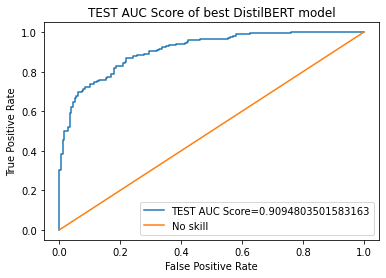

In [66]:
classification_report_dl(
    model = best_distil_model,
    test_data = [X_test_ids, X_test_attention],
    test_label = y_test.to_numpy(),
    model_name="DistilBERT model",
)